In [3]:
"""Importing libraries for formatting and pre-processing the data"""
import pandas as pd
import numpy as np
import pprint
import json
import scipy
import sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

The Format class standardises the formatting of the EU, UK and US databases due to the different conventions used. The RegularFormatter method checks the file type of the database and regularises the date, type and organsisation. The CountryFormatter creates a column with the country of each database.

In [4]:
class Format():
    #initialises the data and df attribute with the data name and an empty dataframe respectively
    def __init__(self, dataName): 
        self.dataName = dataName
        self.df = pd.DataFrame()
    #RegularFormatter Method returns a formatted dataframe for each country 
    def RegularFormatter(self): 
        #checks if file is a JSON file
        if ".json" in self.dataName: #if it is a JSON file, check if it is eu or us
            if 'eu' in str(self.dataName):  #reads JSON file with pandas method 
                self.df = pd.read_json(self.dataName) #transpose the dataframe
                self.df = self.df.T  
            if 'us' in str(self.dataName): 
                with open(self.dataName) as json_file:
                    data = json.load(json_file) #read json file using with open because file contains a nested dictionary
                Df = pd.json_normalize(data, max_level=1) #use pandas json_normalize method to get dataframe containing 
                for i in list(Df.columns):
                    val = Df[i]
                    for m in val.values:
                        x = pd.DataFrame.from_dict(m)
                        x['Date Collected'] = pd.to_datetime(x['Date Collected'], format='%m-%d-%y') 
                        x['Date Collected'] = x['Date Collected'].dt.strftime('%d/%m/%y') #converts mm/dd/yy format to dd/mm/yy
                        x['Type'] = x['Type'].astype(int) #converts 'Type' values from float to integer
                        x['Organization'] = str(i) #creates the "Organisation" column and assigns the organisation for each row of data
                        self.df = pd.concat([self.df, x], ignore_index=True) #concats the dataframes into one dataframe
                         
        if ".csv" or ".evidence" in self.dataName: #checks if the filetype is '.csv' or '.evidence'
            if 'uk' in str(self.dataName): #checks if the file is from a UK glass database
                self.df = pd.read_csv(self.dataName) #reads the csv file 
            if '.evidence' in str(self.dataName): #checks if the file is the evidence file 
                self.df = pd.read_csv(self.dataName, sep = ' ')

        #one-liner function to replace all NaN values with a dictionary of mean values for corresponding values
        self.df = self.df.fillna(self.df.mean()) 

        #The code below replaces the 0 values of the RI column with the mean depending on the glass type which is saved in the meanList dictionary
        if 'Type' in self.df.columns: 
            meanList = {}
            self.df['RI'] = self.df['RI'].replace(0, np.nan)
            for i in [1,2,3,5,6,7]:
                typeDf = self.df.loc[self.df['Type'] == i]
                mean = typeDf['RI'].mean()
                meanList[i] = mean
        
            self.df['RI'] = self.df['RI'].fillna(self.df['Type'].apply(lambda x: meanList.get(x))) #Replaced the NaN values with the corresponding mean RI per type
        else:
            pass
        
        return self.df 
    
    
    #CountryFormatter method eliminates the unnecessary columns from the databases and adds a country column to classify which glass belongs to which country 
    def CountryFormatter(self):
        self.df = self.RegularFormatter()
        self.df = self.df.loc[:, :'Type'] #deletes unnecessary columns
        if 'uk' in self.dataName: #adds a country column
            self.df.loc[:, 'country'] = 'uk'
        if 'us' in self.dataName:
            self.df.loc[:, 'country'] = 'us'
        if 'eu' in self.dataName:
            self.df.loc[:, 'country'] = 'eu'

        return self.df 


In [5]:

uk = Format('glass_uk.csv').CountryFormatter() #Formats and preprocesses the 'glass_uk.csv' file 
us = Format('glass_us.json').CountryFormatter() #Formats and preprocesses the 'glass_us.json' file
eu = Format('glass_eu.json').CountryFormatter() #Formats and preprocesses the 'glass_eu.json' file

data = pd.concat([uk, us, eu], ignore_index= True) #combines the dataframes UK, US, and EU into one dataframe
data.pop(data.columns[0]) #eliminates the repeated index column 
data.to_csv('FullData.csv') #saves the formatted dataframe into a '.csv' file 

The Preprocessor class firstly encodes the data using the Encoder method in which OneHot or Label encoding can be selected by the user. The data is fit and scaled using either Minmax or Standard scaling and returns a dataframe. 

In [6]:
class Preprocessor:
    
    def __init__(self, data):
        self.df = data
        

    def Encoder(self, column):
        if 'Exhibit' not in self.df.columns:
            # Find the unique values in the column of interest
            categories = pd.get_dummies(self.df[str(column)])

            encoded = pd.DataFrame()
            # Create a column for each unique value and one hot encode columns
            
            self.df = pd.concat([self.df, categories], axis = 1)
            return self.df
        else:
            pass


    def Scaler(self, sKind):
        try:
            #if statement chooses what type of scaling we want
            if sKind == 'standard':
                sca = StandardScaler()
            
            elif sKind == 'minmax':
                sca = MinMaxScaler()

        #returns an error if the scale type is not 'standard' or 'minmax'
        except ValueError:
            print('You have not selected standard or minmax scaler')

        #scales the data only for the columns that we want scaled
        colsToScale = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']

        for col in colsToScale:
            self.df[col] = pd.DataFrame(sca.fit_transform(pd.DataFrame(self.df[col])))

        return self.df #returns the scaled dataframe

In [7]:
""" Formatting and pre-processing the samples file """
samples1 = Format('samples.evidence')
samples1.RegularFormatter()
samples1.df.drop('Exhibit', axis = 1)
samples2 = Preprocessor(samples1.df)
samples2.Scaler('minmax') # can choose between 'minmax' and 'standard'
samples2.df.to_csv('samples_preprocessed.csv')


In [8]:
""" Preprocessing the database """
DataBase = pd.read_csv('FullData.csv')
DataBase = Preprocessor(DataBase)
DataBase.Scaler('minmax') # can choose between 'minmax' and 'standard'
DataBase.df.pop(DataBase.df.columns[0])
DataBase.df.to_csv("FullData_Preprocessed.csv")

In [9]:
""" 
Oversampling the data and using SMOTE or Random Oversampling to generate more data samples.
Undersampling was not chosen in order to preserve rather than exclude the given data for the training process.
"""
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

# this class generates more samples 
class ImbalancedDataHandling:
    def __init__(self, data, oversampler):
        self.df = data
        self.oversampler = oversampler 

    # Using SMOTE and Random Oversampling
    def oversampling(self):
        y_column = 'Type'
        X_columns = list(self.df.columns.drop('Type'))

        X = self.df[X_columns]
        y = self.df[y_column]

        if self.oversampler == 'smote':
            os = SMOTE(sampling_strategy = 'auto', random_state = 42, k_neighbors = 5)

        if self.oversampler == 'ros':
            os = RandomOverSampler(sampling_strategy = 'auto', random_state = 42)

        X_res, y_res = os.fit_resample(X, y)

        self.df = pd.concat([X_res, y_res], axis = 1)

        return self.df

In [10]:
data = pd.read_csv('FullData_Preprocessed.csv')
data = data.drop('country', axis = 1)
data = data.drop(data.columns[0], axis = 1)
data_os = ImbalancedDataHandling(data, 'smote').oversampling() # can choose between 'smote' and 'ros'
data_os.to_csv('FullData_os.csv')
OSDb = data_os.to_csv('FullData_os.csv')

In [11]:
""" Importing libraries for the Classifier class """
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.multiclass import OneVsRestClassifier
import sklearn.model_selection 
import sklearn.metrics 
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.datasets import make_classification

import warnings

Choice of classifiers:

Data splitting: 
The data_splitting method splits the data into the train and test sets by omitting the Type column. To ensure that the number of splits of the data remains greater than or equal to 5 the training ratio is updated depending on the y training data. These lines of code were added since the least populated class had less than five members.
    
Support Vector Machine (SVM):
Sklearn.svm.SVC was used in order to build the Support Vector Machine classifier for multi-class classification with a one-versus-rest classification in order to compare a chosen value to all other values. Two hyperparameters were optimised in SVM with GridSearchCV 'gamma' and 'C'. While C adds a penalty for each misclasssified data point, gamma controls the distance of the influence of a single training point when the non-linear kernel, the radial basis function (RBF) kernel is used. Gamma is aimed to a be a low value between 0.0001 and 10 to avoid overfitting while C is aimed to be between 0.1 and 100, a large value to avoid generalized models.

Logistic Regression (LR):
Sklearn.linear_model.Logistic Regression was used in order to build the multinomial Logistic Regression classifier for multi-class classification using GridSearchCV in order to choose the best solver, regularisation penalty and C value, and finally predict the class of each sample.
    
K Nearest Neighbours (KNN):
Sklearn.nieghbors.KNeighborsClassifier was used in order to build the K Nearest Neighbours classifier for multi-class classification by varying the number of neighbours selected. 

Two hyperparameters were optimised in KNN with GridSearchCV 'weights' and 'algortithm'. The weights was selected as 'distance' to allow for closer neighbours to have a greater weight and further neighbours to have a lesser weight to avoid skewing the data when assigning a label. In making the algortithm set to 'auto' the best search method out of ‘ball tree’, ‘kd_tree’ and ‘brute’ is automically selected vased on the data. The number of neighbours was input as a dictionary to allow for the best number of neighbours to be output within the range of the complete data length.

For all classifiers the use of GridSearchCV reduces the risk of overfitting the models and poorly assigning biased labels to the evidence samples. The random state of 42 ensured that the sets were sufficiently shuffled each time and is a default value. 

In [12]:
class Classifier():
    """
    This class contains three types of classifiers: SVM, Logistic regression and KNN. 
    The required inputs are the dataframe containing the full dataset, the sample data,
    the type of scores to be displayed and the training ratio, which is 0.5 by default.
    """
    #initialises data, X_mystery, training_ratio, scoring
    def __init__(self, data, X_mystery, scoring, training_ratio = 0.5):
        self.data = data
        self.X_mystery = X_mystery
        self.training_ratio = training_ratio
        self.scoring = scoring

    def data_splitting(self):
        """
        This method attribute takes no input. It carries out a train-test-split on the 
        dataset based on the training ratio. It outputs X and y training and testing datasets.
        """
        y_column = 'Type'
        X_columns = list(self.data.columns.drop('Type'))

        X = self.data[X_columns]
        y = self.data[y_column]
        
        # test train split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, train_size=self.training_ratio, random_state = 42)     

        # ensuring least populated class in y is not less than n_splits = 5
        y_list = list(self.y_train)
        while any(y_list.count(n) < 5 for n in [1,2,3,5,6,7]):
            self.training_ratio += 0.1
            print(f'Training ratio increased to {self.training_ratio} as least populated class in y is less than 5')

            # carry out test train split again
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, train_size=self.training_ratio)
            y_list = list(self.y_train)
                    
        return

  
    def SVM(self):
        """
        This method attribute trains the SVM model using training data, and outputs
        a score and prediction based on the testing data. It also predicts the 
        glass type of each sample data. 
        """
        #defining parameter dictionary
        param_grid ={
            'C': np.logspace(-4, 2, 10), 
            'gamma': np.logspace(-2, 1, 10), 
            'kernel': ['rbf'],
            'decision_function_shape': ['ovr']
        }
        # using GridSearchCV to optimise hyperparameters
        grid = GridSearchCV(SVC(random_state = 42), param_grid, refit = 'accuracy', scoring = self.scoring)

        # do fitting using train set
        grid.fit(self.X_train, self.y_train)

        # check score of fit using test set
        score = grid.score(self.X_test, self.y_test)

        # predict the type of mystery glass
        prediction = grid.predict(self.X_mystery)

        # make y_pred for further scoring
        y_pred = grid.predict(self.X_test)

        return score, prediction, grid.best_index_, grid.cv_results_, y_pred
    
    def Logistic(self):
        """
        This method attribute trains the Logistic regression model using training data, 
        and outputs a score and prediction based on the testing data. It also 
        predicts the glass type of each sample data. 
        """
        # defining parameters for use in GridSearchCV in a dictionary
        param_grid = {
            #'saga':{'penalty': ['elasticnet'], 'C' : np.logspace(-3, 3, 10), 'l1_ratio': np.linspace(0.1, 0.9, 5)},
            'newton-cg':{'penalty': ['l2'], 'C' : np.logspace(-3, 3, 10)},
            'lbfgs':{'penalty': ['l2'], 'C' : np.logspace(-3, 3, 10)},
            'liblinear':{'penalty': ['l1', 'l2'], 'C' : np.logspace(-3, 3, 10)}
        }

        # the for-loop and the dictionaries account for incompatability between
        # some solvers and the regularisation techniques
        scores_dict = {}
        estimator_dict = {}
        results_dict = {}
        index_dict = {}
        for i in param_grid.keys(): 
            grid = GridSearchCV(LogisticRegression(multi_class = 'ovr', max_iter = 500, solver = i, random_state = 42), param_grid[i], refit = 'accuracy', n_jobs = -1, scoring = self.scoring) 
        
            # fitting the model for grid search 
            grid.fit(self.X_train, self.y_train)

            scores_dict[i] = grid.best_score_
            estimator_dict[i] = grid.best_estimator_
            index_dict[i] = grid.best_index_
            results_dict[i] = grid.cv_results_


        # choosing best solver, penalty and C value
        best_score = max(scores_dict.values())
        for key, value in scores_dict.items():
            if value == best_score:
                best_estimator = estimator_dict[key]
                best_index = index_dict[key]
                best_cv_results = results_dict[key]

        # final fitting using the logistic regression model that has been optimised
        model = best_estimator 
        model.fit(self.X_train, self.y_train)

        # check score of fit uisng testing data
        score = model.score(self.X_test, self.y_test)

        # predict the type of mystery glass
        prediction = model.predict(self.X_mystery)

        # make y_pred for further scoring
        y_pred = model.predict(self.X_test)
        
        return score, prediction, best_index, best_cv_results, y_pred
        
    def KNN(self):
        """
        This method attribute trains the SVM model using training data, and outputs
        a score and prediction based on the testing data. It also predicts the 
        glass type of each sample data. 
        """
        param_grid = {'n_neighbors': np.arange(1, 98, 1)} #the range should be the len of the data 
              
        # using grid search to incorporate the knn classifier and get a report of scores 
        grid = GridSearchCV(KNeighborsClassifier(weights = 'distance', algorithm = 'auto'), param_grid, scoring = self.scoring, refit = 'accuracy')
        
        # fit using train set
        grid = grid.fit(self.X_train, self.y_train)
        
        # check score of fit using test set
        score = grid.score(self.X_test, self.y_test)

        # predict the type of mystery glass
        prediction = grid.predict(self.X_mystery)

        # make y_pred for further scoring
        y_pred = grid.predict(self.X_test)
        
        return score, prediction, grid.best_index_, grid.cv_results_, y_pred

    def scorer(self):
        """
        This method attribute runs SVM(), Logistic() and KNN() and obtains the score of 
        each classifier. It saves the scores and predicted glass types of the sample data
        in two seperate dataframes, which is used for plotting the two graphs later.

        This method also prints a confusion matrix for each classifier to help visualise
        the predictivity of each classifier. 
        """
        
        scorer_dict = {'Scorer' : [f'{n}' for n in self.scoring]}
        prediction_dict = {'Exhibit' : ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']}
        cm_dict = {}

        classifiers = [self.SVM, self.Logistic, self.KNN]
        for n in classifiers:
            scores_list = []
            score, prediction, index, cv_results, y_pred = n()

            # dataframe for bar graph
            cv_results = pd.DataFrame(cv_results)
            best_cv = cv_results.iloc[index]
            for i in self.scoring:
                score_name = f'mean_test_{i}'
                scores_list.append(best_cv[score_name])
            scorer_dict[n.__name__] = scores_list

            # dataframe for scatter plot 
            prediction_dict[n.__name__] = prediction
                            

            # for confusion matrix
            cm_dict[n.__name__] = y_pred
            
        score_table = pd.DataFrame(scorer_dict)
        prediction_table = pd.DataFrame(prediction_dict)

        # creating a confusion matrix
        matrix_dict = {}
        for key, value in cm_dict.items():
            cm = confusion_matrix(self.y_test, value)
            disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [1,2,3,5,6,7])
            matrix_dict[key] = disp.plot()
            disp.ax_.set_title(key)
        
        return score_table, prediction_table

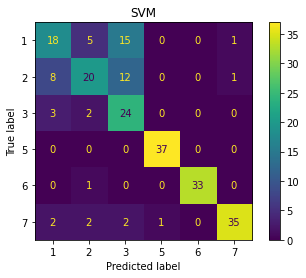

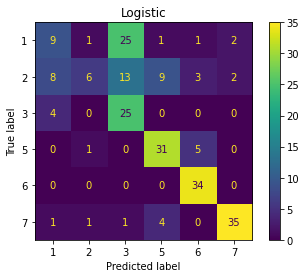

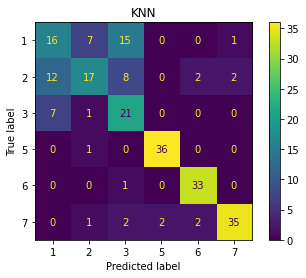

In [13]:
""" Inputting the full dataframe and evidence dataframe to call on the Classifier class
"""
# obtaining inputs for Classifier arguments 
# data
data = pd.read_csv('FullData_os.csv')
data = data.drop(data.columns[[0]], axis = 1)
data = data.drop(data.columns[10:], axis = 1)

# X_mystery
X_mystery = pd.read_csv('samples_preprocessed.csv')
X_mystery = X_mystery.drop([X_mystery.columns[0]], axis=1) 
X_mystery = X_mystery.drop('Exhibit', axis = 1)
X_mystery.to_numpy()

# scoring
scoring = ['accuracy', 'f1_macro', 'f1_weighted']

# creating instance of Classifier  
a = Classifier(data, X_mystery, scoring)

# calling the method 'data_splitting'
a.data_splitting()

# calling the method 'scorer' 
score_table, prediction_table = a.scorer()

Interactive graphs:

The scatter plot allow the user to compare the Predictid Type versus Exhibit concerning the 7 mystery samples. This is achieved with interactive RadioButtons which can choose from the three classifers and identify certain overlaps between their predictions. SVM tends to fully overlap with the points of LR and KNN which suggests a good predictivty of each classifier in general.
    
The bar plot allows the user to compare the the classifiers versus three different types of scores (accuracy, f1_macro, f1_weighted) which are universal to all three classifiers. It provides the user with interactive RadioButtons to choose from the nine variables which influence glass type and when clicking on a button allowing them to re-run the code by NOT including that certain column in the data and evidence files.


In [14]:
"""
The interactive element of the notebook was initialised to allow the plotting 
and interactivity of graphs, and the necessary functions imported
"""

%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.widgets

class Graph():
    """
    This class creates an interactive figure containing a plot of predictions for sample data, 
    and a bar chart containing various scores of the three classifiers
    """
    # initialising score_table and predicted_table
    def __init__(self, score_table, predicted_table):
        self.scores = score_table
        self.predictions = predicted_table
        
        # creating figure and axes
        self.fig, self.ax = plt.subplots(ncols = 2, figsize = (10, 5))
        plt.subplots_adjust(left = 0.15)
        
    def scatter(self):
        """
        This method attribute outputs a scatter plot of prediction against exhibit. 
        """
        # set axis label and tick marks
        self.ax[0].set_xlabel('Exhibit')
        self.ax[0].set_xticks(np.arange(0,8))
        self.ax[0].set_xticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])
        
        self.ax[0].set_ylabel('Predicted Type')

        # defining x and y
        x = np.arange(0,8)
        x_labels = self.predictions['Exhibit']

        y_SVM = self.predictions['SVM']
        y_Logistic = self.predictions['Logistic']
        y_KNN = self.predictions['KNN']
        
        # creating scatter plots
        l1 = self.ax[0].scatter(x, y_SVM, c = 'r', alpha = 0.1)
        l2 = self.ax[0].scatter(x, y_Logistic, c = 'b', alpha = 0.1)
        l3 = self.ax[0].scatter(x, y_KNN, c = 'g', alpha = 0.1)
        lines = {'SVM' : l1, 'LR' : l2, 'KNN' : l3}
        
        return lines

    def bar(self):
        """
        This method attribute outputs a bar graph showing the various scores for each of the three
        classifiers.
        """
        # set height of bar
        SVM = self.scores['SVM']
        LR = self.scores['Logistic']
        KNN = self.scores['KNN']
        
        # Set position of bar on X axis
        barWidth = 0.25
        br1 = np.arange(len(SVM))
        br2 = [x + barWidth for x in br1]
        br3 = [x + barWidth for x in br2]
        
        # Make the plot
        self.ax[1].bar(br1, SVM, color ='r', width = barWidth,
                edgecolor ='grey', label ='SVM')
        self.ax[1].bar(br2, LR, color ='b', width = barWidth,
                edgecolor ='grey', label ='LR')
        self.ax[1].bar(br3, KNN, color ='g', width = barWidth,
                edgecolor ='grey', label ='KNN')
        
        # Adding x ticks and labels 
        xticklabels = self.scores['Scorer']
        self.ax[1].set_ylabel('Score')
        self.ax[1].set_xticks([r + barWidth for r in range(len(SVM))])
        self.ax[1].set_xticklabels(xticklabels)
        
        # legend
        self.ax[1].legend(bbox_to_anchor = (1,1))

        return 
    
    def radio(self):
        """
        This method attribute creates two panels of radiobuttons. The top panel controls the transparency of 
        the points on the scatter plot so that the predictions for each classifier can be observed one at a time.
        The bottom panel removes one parameter and re-runs the classifiers, then re-plots the scatter and bar plot. 
        """
        self.lines1 = self.scatter()
        self.bar()
        
        # creating 1st radio box to control classifier choice 
        radio1_ax = plt.axes([0.0, 0.65, 0.1, 0.2], facecolor='#FFC0CB')
        variables = ('SVM', 'LR', 'KNN')
        radio1 = matplotlib.widgets.RadioButtons(radio1_ax, labels = variables, active = None)
        
        def callback(label):
            """
            This function changes the alpha value of the scatter plot which changes the transparency of the data points.
            """
            for key, value in self.lines1.items():
                if key == label:
                    value.set_alpha(1)
                else:
                    value.set_alpha(0)
            return
        
        radio1.on_clicked(callback)
        
        # creating 2nd radio box to control removal of parameters
        radio2_ax = plt.axes([0.0, 0.1, 0.1, 0.5], facecolor='#FFC0CB')
        variables2 = ('RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe')
        radio2 = matplotlib.widgets.RadioButtons(radio2_ax, labels = variables2, active = None)
            
        def callback2(label):
            """
            This function creates copies of the full data, then drops the column of data corresponding to the selected
            parameter. It then re-runs the classifiers and re-plots the graphs. 
            """
            # making copies of dataframes
            data_copy = data.copy()
            X_mystery_copy = X_mystery.copy()

            # dropping columns 
            data_ = data_copy.drop(label, axis = 1)
            X_mystery_ = X_mystery_copy.drop(label, axis = 1)
            
            # re-running Classifier
            scoring = ['accuracy', 'f1_macro', 'f1_weighted'] 
            a = Classifier(data_, X_mystery_, scoring)
            a.data_splitting()
            self.scores, self.predictions = a.scorer()
            
            # clearing old plots
            self.ax[0].clear()
            self.ax[1].clear()
            
            # refreshing graphs with updated data
            self.lines1 = self.scatter()
            self.bar()
            
            return

        radio2.on_clicked(callback2)
        
        return radio1, radio2
        

<IPython.core.display.Javascript object>


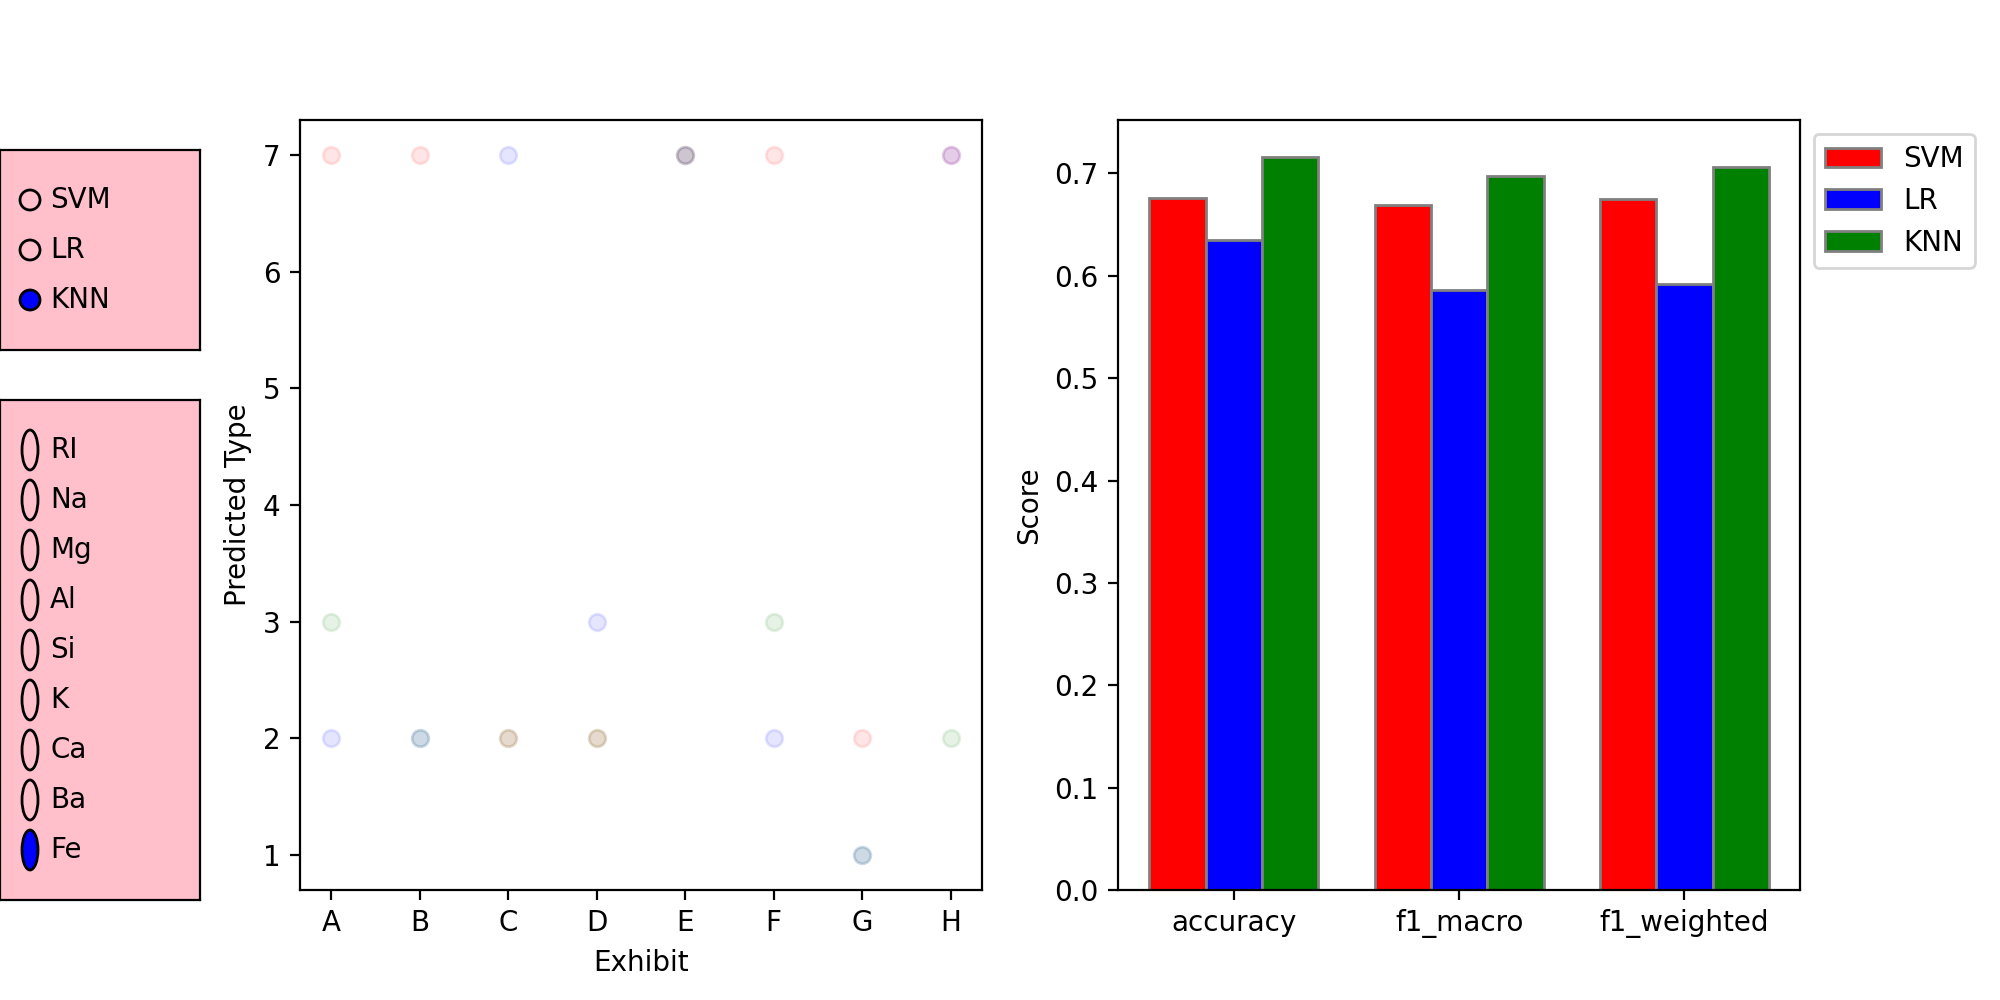

(<matplotlib.widgets.RadioButtons at 0x2270388d5b0>,
 <matplotlib.widgets.RadioButtons at 0x227038cee80>)

In [15]:
# plotting graphs
graph = Graph(score_table, prediction_table)
graph.radio()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=09416adb-7af4-42ba-b05e-496f94b0bd5d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

Observing the changes in scores after deleting a particular column, we found out that deleting the Aluminium column affects the score of the classifiers most.